# **Predicting User Churn for an E-commerce Platform**

## **Objective**
The goal of this project is to:
1. Predict which users are most likely to churn (i.e., stop returning or purchasing).
2. Provide actionable insights to improve user retention based on user behavior patterns.

In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn xgboost shap


Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Feature Importance
import shap


In [3]:
# Load dataset
data = pd.read_csv('events.csv')

# Inspect data
print("Data Preview:")
print(data.head())

print("\nData Info:")
print(data.info())

print("\nMissing Values:")
print(data.isnull().sum())


Data Preview:
                event_time event_type  product_id          category_id  \
0  2020-09-24 11:57:06 UTC       view     1996170  2144415922528452715   
1  2020-09-24 11:57:26 UTC       view      139905  2144415926932472027   
2  2020-09-24 11:57:27 UTC       view      215454  2144415927158964449   
3  2020-09-24 11:57:33 UTC       view      635807  2144415923107266682   
4  2020-09-24 11:57:36 UTC       view     3658723  2144415921169498184   

                   category_code        brand   price              user_id  \
0          electronics.telephone          NaN   31.90  1515915625519388267   
1    computers.components.cooler       zalman   17.16  1515915625519380411   
2                            NaN          NaN    9.81  1515915625513238515   
3  computers.peripherals.printer       pantum  113.81  1515915625519014356   
4                            NaN  cameronsino   15.87  1515915625510743344   

  user_session  
0   LJuJVLEjPT  
1   tdicluNnRY  
2   4TMArHtXQy  
3   

In [6]:
# Convert 'event_time' to datetime
data['event_time'] = pd.to_datetime(data['event_time'])

# Drop rows with missing critical values
data.dropna(subset=['category_code', 'brand', 'price'], inplace=True)

# Remove duplicates
data = data.drop_duplicates()

# Verify cleaning
print("\nData after cleaning:")
print(data.info())



Data after cleaning:
<class 'pandas.core.frame.DataFrame'>
Index: 515946 entries, 1 to 885128
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   event_time     515946 non-null  datetime64[ns, UTC]
 1   event_type     515946 non-null  object             
 2   product_id     515946 non-null  int64              
 3   category_id    515946 non-null  int64              
 4   category_code  515946 non-null  object             
 5   brand          515946 non-null  object             
 6   price          515946 non-null  float64            
 7   user_id        515946 non-null  int64              
 8   user_session   515855 non-null  object             
 9   date           515946 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(3), object(5)
memory usage: 43.3+ MB
None


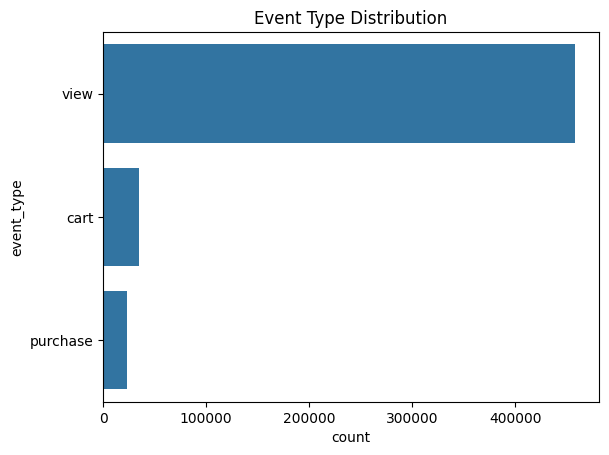

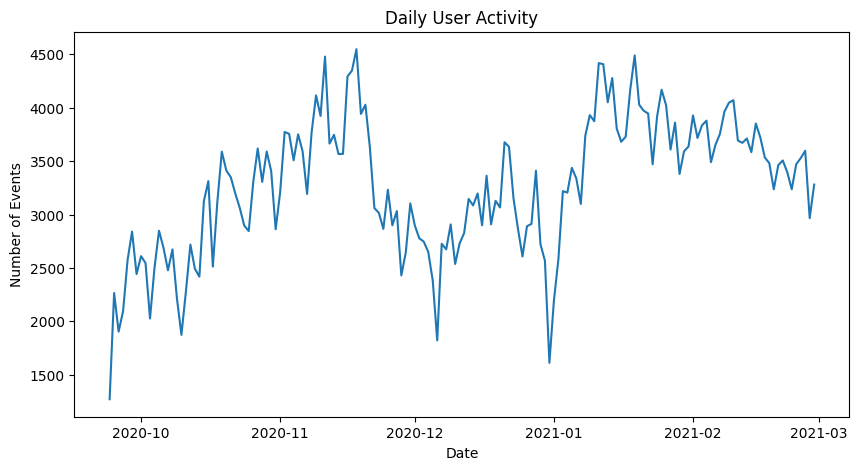

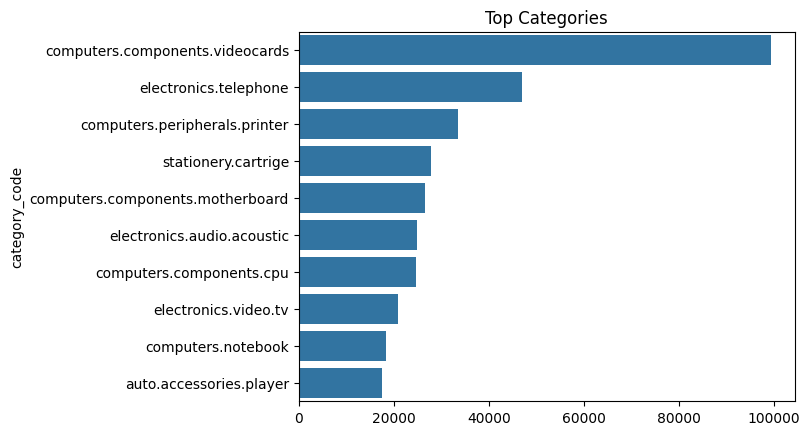

In [7]:
# Event Type Distribution
sns.countplot(data['event_type'])
plt.title("Event Type Distribution")
plt.show()

# Daily Activity
data['date'] = data['event_time'].dt.date
daily_activity = data.groupby('date').size()

plt.figure(figsize=(10, 5))
daily_activity.plot()
plt.title("Daily User Activity")
plt.xlabel("Date")
plt.ylabel("Number of Events")
plt.show()

# Top 10 Categories
top_categories = data['category_code'].value_counts().head(10)
sns.barplot(x=top_categories.values, y=top_categories.index)
plt.title("Top Categories")
plt.show()


In [9]:
# Example user-level metric: Total spend
user_metrics = data.groupby('user_id').agg({
    'price': 'sum',
    'event_time': ['min', 'max', 'count']
})
user_metrics.columns = ['total_spend', 'first_activity', 'last_activity', 'event_count']
user_metrics['average_days_between_visits'] = (user_metrics['last_activity'] - user_metrics['first_activity']).dt.days / user_metrics['event_count']
user_metrics.head()


,total_spend,first_activity,last_activity,event_count,average_days_between_visits
user_id,,,,,
1515915625353226922,76.48,2020-10-29 11:28:35+00:00,2020-10-29 11:28:35+00:00,1,0.000000
1515915625353230683,814.93,2020-11-09 08:52:51+00:00,2020-12-12 10:33:09+00:00,13,2.538462
1515915625353230922,274.40,2020-10-02 08:23:40+00:00,2020-10-02 08:23:40+00:00,1,0.000000
1515915625353234047,5467.71,2020-09-29 16:01:54+00:00,2021-02-18 09:11:44+00:00,35,4.028571
1515915625353236157,52.49,2021-02-11 15:50:40+00:00,2021-02-11 15:50:40+00:00,1,0.000000


In [10]:
# Define churn: Users without purchases in the last 30 days
last_date = data['event_time'].max()
churn_threshold = last_date - pd.Timedelta(days=30)

# Calculate last event date for each user
user_last_event = data.groupby('user_id')['event_time'].max()

# Identify churned users
churned_users = user_last_event[user_last_event < churn_threshold].index

# Add churn label to the dataset
data['churn'] = data['user_id'].apply(lambda x: 1 if x in churned_users else 0)

print("\nSample data with churn labels:")
print(data[['user_id', 'event_time', 'churn']].head())



Sample data with churn labels:
               user_id                event_time  churn
1  1515915625519380411 2020-09-24 11:57:26+00:00      1
3  1515915625519014356 2020-09-24 11:57:33+00:00      1
5  1515915625519388062 2020-09-24 11:57:59+00:00      1
7  1515915625519388882 2020-09-24 11:58:24+00:00      1
9  1515915625519388929 2020-09-24 11:58:31+00:00      1


In [14]:
# Define churn
last_event = data.groupby('user_id')['event_time'].max().reset_index()
last_event['churn_date'] = last_event['event_time'] + pd.Timedelta(days=30)
current_date = data['event_time'].max()
last_event['is_churned'] = last_event['churn_date'] < current_date
data = data.merge(last_event[['user_id', 'is_churned']], on='user_id')


In [15]:
data['days_since_last_event'] = (current_date - data['event_time']).dt.days
user_features = data.groupby('user_id').agg({
    'days_since_last_event': 'min',
    'event_time': 'count',
    'price': 'sum',
    'event_type': lambda x: x.value_counts().to_dict()
}).reset_index()

user_features.columns = ['user_id', 'recency', 'frequency', 'monetary', 'event_type_distribution']
user_features.head()


,user_id,recency,frequency,monetary,event_type_distribution
0,1515915625353226922,122,1,76.48,{'view': 1}
1,1515915625353230683,78,13,814.93,{'view': 13}
2,1515915625353230922,149,1,274.40,{'view': 1}
3,1515915625353234047,10,35,5467.71,{'view': 35}
4,1515915625353236157,17,1,52.49,{'view': 1}


In [16]:
# RFM Features
rfm = data.groupby('user_id').agg({
    'event_time': lambda x: (last_date - x.max()).days,  # Recency
    'user_session': 'nunique',  # Frequency
    'price': 'sum'  # Monetary
}).reset_index()

rfm.columns = ['user_id', 'recency', 'frequency', 'monetary']

# Add churn labels
rfm['churn'] = rfm['user_id'].apply(lambda x: 1 if x in churned_users else 0)

# Behavioral Features
behavior_features = data.groupby('user_id').agg({
    'event_type': lambda x: (x == 'view').sum(),  # Total views
    'category_code': 'nunique'  # Unique categories viewed
}).reset_index()

behavior_features.columns = ['user_id', 'total_views', 'unique_categories']

# Combine all features
final_data = pd.merge(rfm, behavior_features, on='user_id')
print("\nFinal Feature Set:")
print(final_data.head())



Final Feature Set:
               user_id  recency  frequency  monetary  churn  total_views  \
0  1515915625353226922      122          1     76.48      1            1   
1  1515915625353230683       78          4    814.93      1           13   
2  1515915625353230922      149          1    274.40      1            1   
3  1515915625353234047       10          1   5467.71      0           35   
4  1515915625353236157       17          1     52.49      0            1   

   unique_categories  
0                  1  
1                  2  
2                  1  
3                  2  
4                  1  


In [17]:
# Prepare feature set and target variable
X = final_data.drop(columns=['user_id', 'churn'])
y = final_data['churn']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Train Logistic Regression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)

# Predict and Evaluate Logistic Regression
y_pred_lr = lr_model.predict(X_test)
y_pred_prob_lr = lr_model.predict_proba(X_test)[:, 1]

print("\n--- Logistic Regression Results ---")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=["False", "True"]))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))

print("\nLogistic Regression AUC:")
print(roc_auc_score(y_test, y_pred_prob_lr))

# Train Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predict and Evaluate Random Forest
y_pred_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)[:, 1]

print("\n--- Random Forest Results ---")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=["False", "True"]))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

print("\nRandom Forest AUC:")
print(roc_auc_score(y_test, y_pred_prob_rf))


C:\Users\satya\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



--- Logistic Regression Results ---

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.99      1.00      9135
        True       1.00      1.00      1.00     35865

    accuracy                           1.00     45000
   macro avg       1.00      1.00      1.00     45000
weighted avg       1.00      1.00      1.00     45000


Confusion Matrix:
[[ 9060    75]
 [    1 35864]]

Logistic Regression AUC:
0.9999956993746925

--- Random Forest Results ---

Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      9135
        True       1.00      1.00      1.00     35865

    accuracy                           1.00     45000
   macro avg       1.00      1.00      1.00     45000
weighted avg       1.00      1.00      1.00     45000


Confusion Matrix:
[[ 9135     0]
 [    0 35865]]

Random Forest AUC:
1.0


In [25]:
from sklearn.metrics import classification_report, roc_auc_score, log_loss, brier_score_loss
import pandas as pd

# Logistic Regression Metrics
classification_report_lr = classification_report(y_test, y_pred_lr, output_dict=True)
precision_lr = classification_report_lr['1']['precision']  # Use '1' instead of 'True'
recall_lr = classification_report_lr['1']['recall']
f1_score_lr = classification_report_lr['1']['f1-score']
accuracy_lr = classification_report_lr['accuracy']
roc_auc_lr = roc_auc_score(y_test, y_pred_prob_lr)
log_loss_lr = log_loss(y_test, y_pred_prob_lr)
brier_loss_lr = brier_score_loss(y_test, y_pred_prob_lr)

# Random Forest Metrics
classification_report_rf = classification_report(y_test, y_pred_rf, output_dict=True)
precision_rf = classification_report_rf['1']['precision']  # Use '1' instead of 'True'
recall_rf = classification_report_rf['1']['recall']
f1_score_rf = classification_report_rf['1']['f1-score']
accuracy_rf = classification_report_rf['accuracy']
roc_auc_rf = roc_auc_score(y_test, y_pred_prob_rf)
log_loss_rf = log_loss(y_test, y_pred_prob_rf)
brier_loss_rf = brier_score_loss(y_test, y_pred_prob_rf)

# Summarize Results in a Table
metrics_table = pd.DataFrame({
    "Metric": ["Precision", "Recall", "F1 Score", "Accuracy", "ROC-AUC", "Log Loss", "Brier Loss"],
    "Logistic Regression": [precision_lr, recall_lr, f1_score_lr, accuracy_lr, roc_auc_lr, log_loss_lr, brier_loss_lr],
    "Random Forest": [precision_rf, recall_rf, f1_score_rf, accuracy_rf, roc_auc_rf, log_loss_rf, brier_loss_rf]
})

print(metrics_table)


       Metric  Logistic Regression  Random Forest
0   Precision             0.997913   1.000000e+00
1      Recall             0.999972   1.000000e+00
2    F1 Score             0.998942   1.000000e+00
3    Accuracy             0.998311   1.000000e+00
4     ROC-AUC             0.999996   1.000000e+00
5    Log Loss             0.014649   7.717095e-05
6  Brier Loss             0.003545   9.977778e-07


C:\Users\satya\AppData\Local\Temp\ipykernel_9428\420111009.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')


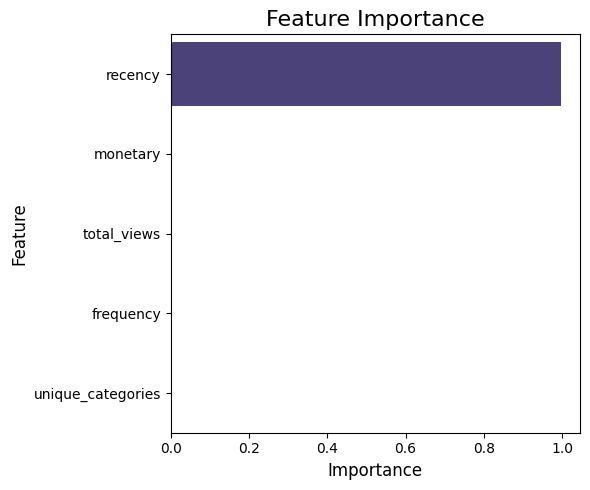

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,  # Ensure X_train.columns matches the trained features
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(6, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
plt.title("Feature Importance", fontsize=16)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()


In [20]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


Shape of SHAP values: (45000, 5, 2)
Shape of X_test: (45000, 5)


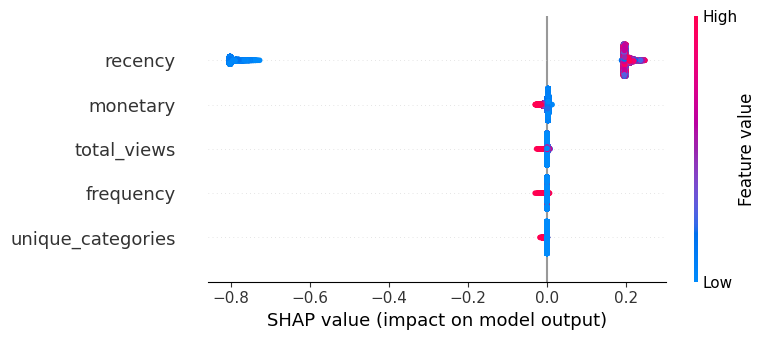

In [21]:
import shap

# Initialize the SHAP explainer
explainer = shap.TreeExplainer(rf_model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

# Check shapes
print("Shape of SHAP values:", shap_values.shape)
print("Shape of X_test:", X_test.shape)

# Generate the SHAP summary plot for the positive class (churn = 1)
shap.summary_plot(shap_values[:, :, 1], X_test, feature_names=X_test.columns)
